In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet


In [9]:
# Load the models
model1 = load_model("EfficinetB0_Brain1.keras")  # EfficientNetB0
model4 = load_model("VGG19_Brain.keras")         # VGG19
model5 = load_model("DenseNet121_Brain.keras")   # DenseNet121

# Directory path for test data
data_dir = "D:\\Brain\\Brain Tumor\\test"


In [3]:
# Define separate data generators for each model using the appropriate preprocessing function
datagen1 = ImageDataGenerator(preprocessing_function=preprocess_efficientnet)
datagen4 = ImageDataGenerator(preprocessing_function=preprocess_vgg19)
datagen5 = ImageDataGenerator(preprocessing_function=preprocess_densenet)

# Create generators
test_gen1 = datagen1.flow_from_directory(data_dir, target_size=(224, 224), class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=False)
test_gen4 = datagen4.flow_from_directory(data_dir, target_size=(224, 224), class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=False)
test_gen5 = datagen5.flow_from_directory(data_dir, target_size=(224, 224), class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=False)

# Predict the labels on the test dataset with each model
predictions1 = model1.predict(test_gen1, steps=len(test_gen1))
predictions4 = model4.predict(test_gen4, steps=len(test_gen4))
predictions5 = model5.predict(test_gen5, steps=len(test_gen5))



Found 1054 images belonging to 4 classes.
Found 1054 images belonging to 4 classes.
Found 1054 images belonging to 4 classes.
33/33 [==============================] - 32s 914ms/step


In [4]:
# Assuming class_indices are ordered alphabetically in your generators
class_indices = test_gen1.class_indices



In [5]:
# Focus EfficientNetB0 on glioma and meningioma
focused_predictions1 = predictions1[:, [class_indices['glioma'], class_indices['meningioma']]]

# Focus VGG19 and DenseNet121 on no tumor and pituitary
focused_predictions4 = predictions4[:, [class_indices['notumor'], class_indices['pituitary']]]
focused_predictions5 = predictions5[:, [class_indices['notumor'], class_indices['pituitary']]]



In [6]:
# Combine predictions: max pooling over the probabilities could be one approach
combined_predictions = np.zeros_like(predictions1)
combined_predictions[:, [class_indices['glioma'], class_indices['meningioma']]] = focused_predictions1
combined_predictions[:, [class_indices['notumor'], class_indices['pituitary']]] = np.maximum(focused_predictions4, focused_predictions5)


In [7]:
# Determine the final predicted class for each sample
final_predicted_classes = np.argmax(combined_predictions, axis=1)

# Get the true labels
true_classes = test_gen1.classes


Accuracy: 96.11%
Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.96      0.96       258
  meningioma       0.94      0.91      0.92       247
     notumor       0.97      0.98      0.98       292
   pituitary       0.97      0.99      0.98       257

    accuracy                           0.96      1054
   macro avg       0.96      0.96      0.96      1054
weighted avg       0.96      0.96      0.96      1054



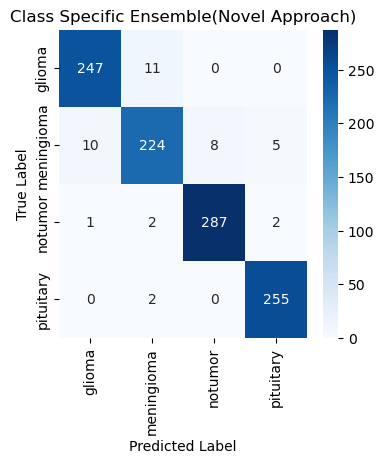

In [8]:
# Calculate the accuracy
accuracy = accuracy_score(true_classes, final_predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate and print the classification report
class_labels = list(test_gen1.class_indices.keys())
report = classification_report(true_classes, final_predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Class Specific Ensemble(Novel Approach)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Compute the confusion matrix
cm = confusion_matrix(true_classes, final_predicted_classes)

# Call the function to plot the confusion matrix
plot_confusion_matrix(cm, class_labels)
